In [5]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import function
from sklearn.preprocessing import MinMaxScaler

In [7]:
df_origin = pd.read_excel('../VisitorEntrancesV3.xlsx')

In [8]:
df = df_origin[df_origin.Site_Name=='Hermon Stream (Banias)']
df = function.remove_unique_one(df)
df = df.drop(df.filter(regex='Season').columns, axis=1)
df = df.drop(df.filter(regex='Exceeded').columns, axis=1)
df = df.drop(df.filter(regex='isHeatwave').columns, axis=1)
df = df.replace({True:1,False:0})

In [9]:
dfWithoutLastYearVisits = df.dropna().drop('last_year_visitors',axis=1)
dfLastYearVisits = df.dropna()

In [10]:
print(dfLastYearVisits.shape)
print(dfWithoutLastYearVisits.shape)

(489, 8)
(489, 7)


In [11]:
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from IPython.display import clear_output
from keras.regularizers import l2

In [12]:
dfLastYearVisits.sort_values('Date')
X = dfLastYearVisits.drop(['Israelis_Count'],axis=1)
y = dfLastYearVisits[['Date','Israelis_Count']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train.drop('Date',axis=1))
X_test_scaled = X_test_scaler.fit_transform(X_test.drop('Date',axis=1))
 
X_train_scaled


X_train_date = X_train.Date
y_train_date = y_train.Date
X_test_date = X_test.Date
y_test_date = y_test.Date

y_train.drop('Date',axis=1,inplace=True)
y_test.drop('Date',axis=1,inplace=True)

In [61]:
# create NN model
model = Sequential()
model.add(Dense(X_train_scaled.shape[1], input_dim=X_train_scaled.shape[1],activation='relu',activity_regularizer=l2(0.01)))
model.add(Dense(128,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(8,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
 

In [62]:
# Compiling the model
model.compile(metrics=['mae','accuracy'], optimizer='adam', loss = 'mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1 )
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=0 )
mcp = ModelCheckpoint(filepath='weightsBanias.h5', monitor='val_loss', verbose=1 , save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_scaled, y_train, shuffle=True, epochs=10000,callbacks=[es, rlr, mcp],validation_split=0.2,batch_size=1)
clear_output(True)


Epoch 1/10000
302/312 [============================>.] - ETA: 0s - loss: 1025143.0000 - mae: 801.1549 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 1800530.87500, saving model to weightsBanias.h5
312/312 [==============================] - 1s 2ms/step - loss: 1028769.2500 - mae: 804.4109 - accuracy: 0.0000e+00 - val_loss: 1800530.8750 - val_mae: 1025.7258 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10000
291/312 [==========================>...] - ETA: 0s - loss: 587016.0625 - mae: 547.5714 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 1800530.87500 to 938886.50000, saving model to weightsBanias.h5
312/312 [==============================] - 1s 2ms/step - loss: 568003.5000 - mae: 536.6995 - accuracy: 0.0000e+00 - val_loss: 938886.5000 - val_mae: 635.9236 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10000
292/312 [===========================>..] - ETA: 0s - loss: 427787.0000 - mae: 471.0097 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 938886.50000 

In [63]:
model.load_weights('weightsBanias.h5')

13/13 [==============================] - 0s 1ms/step

mae 466.9565691935742
rmse 657.3538012975282
std 685.817797847391


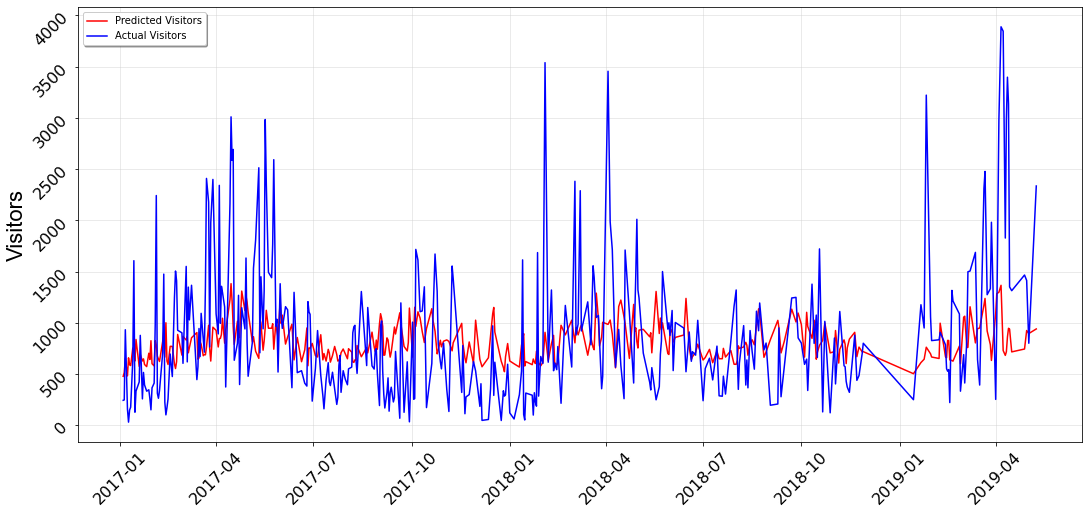

,Prediction,Actual
Date,,
2017-01-04,477.268005,243
2017-01-05,513.496948,247
2017-01-06,651.231934,932
2017-01-08,481.321716,157
2017-01-09,657.682739,30
2017-01-10,589.722534,148
2017-01-11,582.188904,176
2017-01-13,753.509888,638
2017-01-14,708.778137,1606


In [64]:
prediction = model.predict(X_train_scaled)
prediction = prediction.reshape(len(X_train_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_train.values.T[0],
        },
    index=y_train_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

4/4 [==============================] - 0s 2ms/step

mae 408.11961582728793
rmse 515.229493039464
std 520.0167628773802


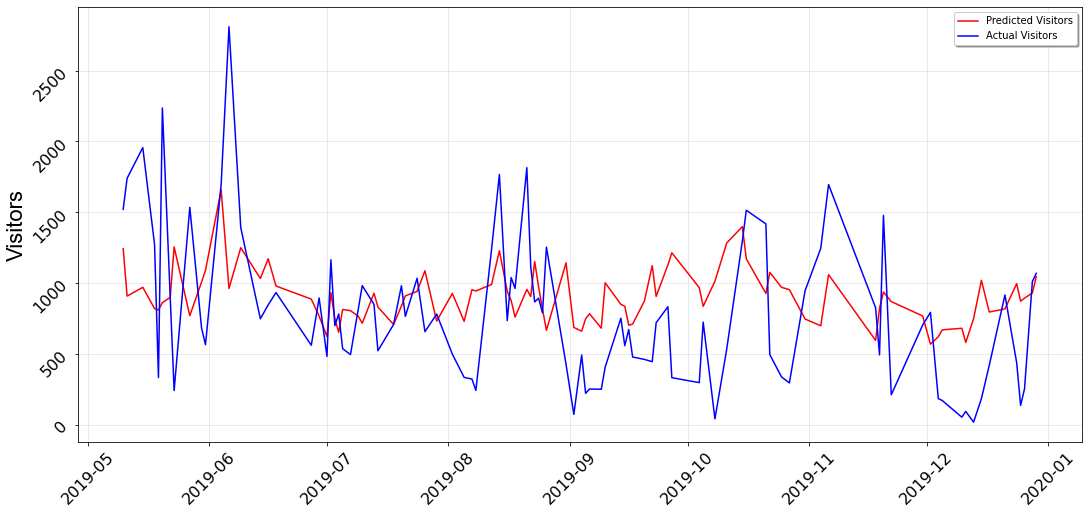

,Prediction,Actual
Date,,
2019-05-10,1242.370483,1520
2019-05-11,907.005127,1739
2019-05-15,969.171448,1956
2019-05-18,819.357544,1273
2019-05-19,808.906067,332
2019-05-20,860.402954,2236
2019-05-22,898.279175,900
2019-05-23,1254.250977,240
2019-05-27,768.774658,1534


In [65]:
prediction = model.predict(X_test_scaled)
prediction = prediction.reshape(len(X_test_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_test.values.T[0],
        },
    index=y_test_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

In [66]:
from lime_stability.stability import LimeTabularExplainerOvr

class_names=['Israelis_Count']

categorical_features = np.argwhere(
    np.array([len(set(X_train_scaled[:,x]))
    for x in range(X_train_scaled.shape[1])]) <= 2).flatten()

print(X_train_scaled.shape)
print(categorical_features.shape)
print(X_train_scaled.shape)

explainer = LimeTabularExplainerOvr(np.array(X_train_scaled),
 feature_names=X_train.drop('Date',axis=1).columns,
 class_names=class_names, 
 categorical_features=categorical_features, 
 verbose=True,
 mode='regression'
 )

i = np.random.randint(len(X_test_scaled))
print('index ', i, ':: Actual values = ', y_test.Israelis_Count.values[i])
print('index ', i, ':: Prediction values = ', prediction.tolist()[i])
exp = explainer.explain_instance((X_test_scaled[i]),model.predict,num_features=100)
exp.show_in_notebook(show_table=True)
function.outputLimeAsDf(exp)


(391, 6)
(3,)
(391, 6)
index  17 :: Actual values =  560
index  17 :: Prediction values =  885.904052734375
157/157 [==============================] - 0s 1ms/step
Intercept 1099.924713738401
Prediction_local [962.59926984]
Right: 885.90405


,0
IsHoliday,290.873668
last year visitors,279.776550
is weekend,123.358785
IsVacation,-74.573932
Temperature,65.887997
pm10,5.816395
